In [64]:
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm

import optuna


# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    iris = sklearn.datasets.load_iris()
    x, y = iris.data, iris.target

    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if classifier_name == 'SVC':
        svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=10)

    score = sklearn.model_selection.cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy


if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    print(study.best_trial)

[I 2020-03-09 00:39:41,791] Finished trial#0 resulted in value: 0.32. Current best value is 0.32 with parameters: {'classifier': 'SVC', 'svc_c': 6.630523771667486e-05}.
[I 2020-03-09 00:39:41,875] Finished trial#1 resulted in value: 0.96. Current best value is 0.96 with parameters: {'classifier': 'SVC', 'svc_c': 3176180490.2298994}.
[I 2020-03-09 00:39:42,006] Finished trial#2 resulted in value: 0.94. Current best value is 0.96 with parameters: {'classifier': 'SVC', 'svc_c': 3176180490.2298994}.
[I 2020-03-09 00:39:42,075] Finished trial#3 resulted in value: 0.96. Current best value is 0.96 with parameters: {'classifier': 'SVC', 'svc_c': 3176180490.2298994}.
[I 2020-03-09 00:39:42,157] Finished trial#4 resulted in value: 0.32. Current best value is 0.96 with parameters: {'classifier': 'SVC', 'svc_c': 3176180490.2298994}.
[I 2020-03-09 00:39:42,263] Finished trial#5 resulted in value: 0.96. Current best value is 0.96 with parameters: {'classifier': 'SVC', 'svc_c': 3176180490.2298994}.
[

[I 2020-03-09 00:39:49,896] Finished trial#88 resulted in value: 0.96. Current best value is 0.9866666666666667 with parameters: {'classifier': 'SVC', 'svc_c': 4.628688360832802}.
[I 2020-03-09 00:39:49,982] Finished trial#89 resulted in value: 0.96. Current best value is 0.9866666666666667 with parameters: {'classifier': 'SVC', 'svc_c': 4.628688360832802}.
[I 2020-03-09 00:39:50,081] Finished trial#90 resulted in value: 0.32. Current best value is 0.9866666666666667 with parameters: {'classifier': 'SVC', 'svc_c': 4.628688360832802}.
[I 2020-03-09 00:39:50,177] Finished trial#91 resulted in value: 0.9199999999999999. Current best value is 0.9866666666666667 with parameters: {'classifier': 'SVC', 'svc_c': 4.628688360832802}.
[I 2020-03-09 00:39:50,256] Finished trial#92 resulted in value: 0.9866666666666667. Current best value is 0.9866666666666667 with parameters: {'classifier': 'SVC', 'svc_c': 4.628688360832802}.
[I 2020-03-09 00:39:50,342] Finished trial#93 resulted in value: 0.97333

FrozenTrial(number=12, value=0.9866666666666667, datetime_start=datetime.datetime(2020, 3, 9, 0, 39, 42, 824301), datetime_complete=datetime.datetime(2020, 3, 9, 0, 39, 42, 891791), params={'classifier': 'SVC', 'svc_c': 4.628688360832802}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest')), 'svc_c': LogUniformDistribution(high=10000000000.0, low=1e-10)}, user_attrs={}, system_attrs={'_number': 12}, intermediate_values={}, trial_id=12, state=TrialState.COMPLETE)


In [62]:
study.best_trial.params

{'classifier': 'SVC', 'svc_c': 4.538374715403419}

In [63]:
module, cls = 'a.b.c'.rsplit('.')

ValueError: too many values to unpack (expected 2)

In [ ]:
import pickle
y_s = pickle.load(open('cache/predictions/y_pred.pickle','rb'))
y = y_s[:, 0:1]

In [ ]:
import numpy as np
np.append(y, y, axis = 1).shape

In [65]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss, precision_score, precision_recall_curve
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LinearRegression, LogisticRegression

import utils.luigi_wrapper as luigi

from preprocess.data_tokenizer import DataTokenizer
from preprocess.questions_label_extractor import QuestionsLabelExtractor
from utils.utils import *


In [66]:
class QuestionsModel(luigi.Task):
    PLOT_ALL_ROCS = luigi.BoolParameter(default=False)
    model = luigi.Parameter(default=LinearRegression())

    def requires(self):
        return {
            'X': DataTokenizer(),
            'y': QuestionsLabelExtractor()
        }

    def output(self):
        return {
            'y_test': luigi.LocalTarget(get_file_path('y_test.pickle', 'data')),
            'y_pred': luigi.LocalTarget(get_file_path('y_pred.pickle', 'predictions'))
        }

    @staticmethod
    def __random_features(X, random_features_size=1000):
        return X.iloc[:, list(np.random.randint(X.shape[1], size=random_features_size))]

    def run(self):
        self.X = self.requires()['X'].load_outputs()
        self.y = self.requires()['y'].load_outputs()

        if self.DATAFRAME:
            self.X = self.X.to_numpy()
            self.y = self.y.to_numpy()
        return self.X, self.y


In [67]:
X, y = QuestionsModel().run()

C:\Alon\Anaconda3\lib\site-packages\luigi\parameter.py:286: UserWarning: Parameter "model" with value "LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))


In [68]:
X

<6221x107142 sparse matrix of type '<class 'numpy.float64'>'
	with 2183708 stored elements in Compressed Sparse Row format>

In [69]:
y

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]])

In [70]:
X.shape, y.shape

((6221, 107142), (6221, 60))

In [71]:
X = X[:1000, :1000]
y = y[:1000, :10]

In [72]:
model = OneVsRestClassifier(LogisticRegression())

In [73]:
y_pred = cross_val_predict(model, X, y, cv = 3, method='predict_proba')

In [74]:
y_pred.shape

(1000, 10)

In [75]:
from sklearn.metrics import roc_auc_score

In [76]:
roc_auc_score(y, y_pred, average="micro")

0.937440427305319

In [77]:
import optuna
import lightgbm as lgb

In [83]:
from optuna.trial import Trial

In [88]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [97]:
def lgb_objective(trial):
    model: BaseEstimator = lgb.sklearn.LGBMClassifier()
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model.set_params(**params)

    model = OneVsRestClassifier(model)

    y_pred = cross_val_predict(model, X, y, method='predict_proba')

    score = roc_auc_score(y, y_pred, average="micro")

    return score

def logistic_objective(trial: Trial):
    model: BaseEstimator = LogisticRegression()
    params = {
        'penalty': trial.suggest_categorical('penalty', ['none', 'l2']),
        'C': trial.suggest_loguniform('C', 0.001, 10),
        'tol': trial.suggest_uniform('tol', 0.00001, 0.0002),
    }

    model.set_params(**params)

    model = OneVsRestClassifier(model)

    y_pred = cross_val_predict(model, X, y, method='predict_proba')

    score = roc_auc_score(y, y_pred, average="micro")

    return score


def get_best_model():
    study = optuna.create_study(direction='maximize')
    study.optimize(lgb_objective, n_trials=10)
    print(study.best_trial)

In [98]:
get_best_model()

[I 2020-03-09 00:47:03,229] Finished trial#0 resulted in value: 0.9387978480881409. Current best value is 0.9387978480881409 with parameters: {'lambda_l1': 4.021511298490878e-05, 'lambda_l2': 0.00038746432865665773, 'num_leaves': 97, 'feature_fraction': 0.5577630948862072, 'bagging_fraction': 0.6301943947881088, 'bagging_freq': 5, 'min_child_samples': 55}.
[I 2020-03-09 00:47:04,933] Finished trial#1 resulted in value: 0.9381388788311198. Current best value is 0.9387978480881409 with parameters: {'lambda_l1': 4.021511298490878e-05, 'lambda_l2': 0.00038746432865665773, 'num_leaves': 97, 'feature_fraction': 0.5577630948862072, 'bagging_fraction': 0.6301943947881088, 'bagging_freq': 5, 'min_child_samples': 55}.
[I 2020-03-09 00:47:06,838] Finished trial#2 resulted in value: 0.9386662186092128. Current best value is 0.9387978480881409 with parameters: {'lambda_l1': 4.021511298490878e-05, 'lambda_l2': 0.00038746432865665773, 'num_leaves': 97, 'feature_fraction': 0.5577630948862072, 'bagging

FrozenTrial(number=4, value=0.9394225621211256, datetime_start=datetime.datetime(2020, 3, 9, 0, 47, 8, 397409), datetime_complete=datetime.datetime(2020, 3, 9, 0, 47, 10, 206977), params={'lambda_l1': 1.3075313306120969e-05, 'lambda_l2': 2.898416646430472e-05, 'num_leaves': 231, 'feature_fraction': 0.910947329716452, 'bagging_fraction': 0.6870754617520984, 'bagging_freq': 5, 'min_child_samples': 60}, distributions={'lambda_l1': LogUniformDistribution(high=10.0, low=1e-08), 'lambda_l2': LogUniformDistribution(high=10.0, low=1e-08), 'num_leaves': IntUniformDistribution(high=256, low=2), 'feature_fraction': UniformDistribution(high=1.0, low=0.4), 'bagging_fraction': UniformDistribution(high=1.0, low=0.4), 'bagging_freq': IntUniformDistribution(high=7, low=1), 'min_child_samples': IntUniformDistribution(high=100, low=5)}, user_attrs={}, system_attrs={'_number': 4}, intermediate_values={}, trial_id=4, state=TrialState.COMPLETE)


In [101]:
study.best_trial

FrozenTrial(number=12, value=0.9866666666666667, datetime_start=datetime.datetime(2020, 3, 9, 0, 39, 42, 824301), datetime_complete=datetime.datetime(2020, 3, 9, 0, 39, 42, 891791), params={'classifier': 'SVC', 'svc_c': 4.628688360832802}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest')), 'svc_c': LogUniformDistribution(high=10000000000.0, low=1e-10)}, user_attrs={}, system_attrs={'_number': 12}, intermediate_values={}, trial_id=12, state=TrialState.COMPLETE)

In [18]:
import numpy as np

In [19]:
# random_features_size = 1000
# X, y = run()
# X = X.iloc[:, list(np.random.randint(X.shape[1], size = random_features_size))]

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, shuffle=True)

In [22]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [23]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred

array([[-0.11064287, -0.00889251, -0.00568587, ...,  0.03339778,
        -0.01330995,  0.65594999],
       [ 0.00392664, -0.12796338,  0.02933872, ...,  0.17471931,
         0.01611429,  0.40149473],
       [-0.01422505,  0.03322306, -0.03086293, ...,  0.91973461,
         0.04077006,  1.16964003],
       ...,
       [ 0.04018666,  0.06118205,  0.03973197, ..., -0.11832357,
         0.04093055,  0.82092035],
       [-0.03576917,  0.04357469,  0.03694765, ...,  0.21934662,
         0.01694625,  0.98192731],
       [-0.01328456, -0.00254824,  0.01949228, ...,  0.10660023,
         0.04239759,  0.54780385]])

In [139]:
def get_precision(y_true, y_pred):
    return ((y_pred == y_true) & (y_pred==1)).sum().sum() / (y_pred==1).sum().sum()

def get_recall(y_true, y_pred):
    return ((y_pred == y_true) & (y_true==1)).sum().sum() / (y_true==1).sum().sum()

def print_precision_recall(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    print('precision is ', precision)
    print('recall is ', recall)
print('### Train ###')
print_precision_recall(y_train, y_train_pred)
print('### Test ###')
print_precision_recall(y_test, y_test_pred)

### Train ###
precision is  1.0
recall is  0.1956521739130435
### Test ###
precision is  1.0
recall is  0.08333333333333333


In [140]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss, precision_score, precision_recall_curve
# print("Accuracy = ",accuracy_score(y,y_pred))
print("acc = ",precision_score(y_test,y_test_pred, average="macro"))
print("F1 = ",f1_score(y_test,y_test_pred, average="micro"))
print("F1 = ",f1_score(y_test,y_test_pred, average="macro"))
print("F1 = ",f1_score(y_test,y_test_pred, average="weighted"))
# print("Hamming loss = ",hamming_loss(y,y_pred))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [141]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

import numpy as np

fpr = dict()
tpr = dict()
roc_auc = dict()
for c_ind, c in enumerate(y.columns):
    fpr_values, tpr_values, _ = roc_curve(y_test[c], y_test_pred[:, c_ind])
    auc_score = auc(fpr_values, tpr_values)
    if not np.isnan(auc_score):
        fpr[c], tpr[c] = fpr_values, tpr_values
        roc_auc[c] = auc_score
roc_auc

C:\Alon\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:788: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Alon\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:780: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Alon\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:88: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


{'agency': 0.5,
 'agent': 0.23076923076923073,
 'alias': 0.6888888888888889,
 'associated_acts': 0.6326530612244898,
 'background': 0.6326530612244898,
 'birth_name': 1.0,
 'birth_place': 0.7999999999999999,
 'caption': 0.7777777777777779,
 'children': 0.8333333333333334,
 'genre': 0.6326530612244898,
 'height': 0.625,
 'image': 0.7708333333333333,
 'image_size': 0.5833333333333333,
 'instrument': 0.525,
 'known_for': 1.0,
 'label': 0.7551020408163266,
 'landscape': 0.5,
 'module': 0.8444444444444444,
 'nationality': 0.5,
 'native_name_lang': 0.875,
 'occupation': 0.3076923076923077,
 'origin': 0.7111111111111111,
 'other_names': 0.6363636363636364,
 'spouse': 0.875,
 'website': 0.7083333333333333,
 'years_active': 0.75}

In [142]:
import matplotlib.pyplot as plt

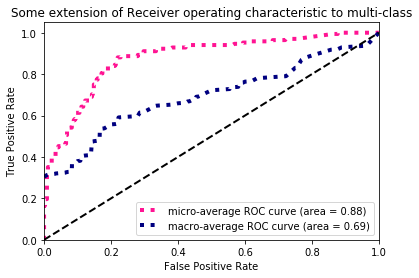

In [150]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[c] for c in fpr.keys()]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for c in fpr.keys():
    mean_tpr += interp(all_fpr, fpr[c], tpr[c])

# Finally average it and compute AUC
mean_tpr /= len(fpr.keys())

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.to_numpy().ravel(), y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

lw = 2

# for c in fpr.keys():
#     plt.plot(fpr[c], tpr[c], lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(c, roc_auc[c]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
f = plt.gcf()
plt.show()

In [154]:
f.savefig('aaa.png')

In [155]:
y

,agency,agent,alias,alma_mater,associated_acts,background,birth_date,birth_name,birth_place,caption,...,native_name_lang,nickname,occupation,origin,other_names,signature,signature_size,spouse,website,years_active
page,,,,,,,,,,,,,,,,,,,,,
Selene Vigil-Wilk,0,0,0,0,1,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
Jay Park,0,0,0,0,1,1,1,1,1,1,...,0,0,1,1,0,0,0,0,1,1
Miho Miyazaki,0,0,1,0,1,1,1,0,0,1,...,1,0,1,1,0,0,0,0,0,1
Wu Xuanyi,0,0,1,0,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
Shizuka Ōya,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
Brad Arnold,0,0,0,0,1,1,1,0,0,0,...,0,0,1,1,0,0,0,0,0,1
Emika Kamieda,0,0,1,0,1,1,1,0,1,1,...,1,0,1,0,0,0,0,0,1,1
Yook Sung-jae,0,0,0,1,0,0,1,1,1,1,...,0,0,1,0,0,1,1,0,0,0
Kazumi Urano,1,0,0,0,0,0,1,0,1,0,...,1,0,1,0,1,0,0,0,0,1


In [1]:
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_predict

import utils.luigi_wrapper as luigi

from preprocess.feature_selection import FeatureSelectionTask
from preprocess.questions_label_extractor import QuestionsLabelExtractor

from utils.utils import *

from questions_models.questions_models_config import get_models
from questions_models.choose_best_model import ModelSelectionTask


In [2]:
class QuestionsModel(luigi.Task):

    def requires(self):
        return {
            'X': FeatureSelectionTask(),
            'y': QuestionsLabelExtractor(),
            'best_model': ModelSelectionTask()
        }

    def output(self):
        return luigi.LocalTarget(get_file_path('y_pred.pickle', 'question_model'))

    def run(self):
        self.X = self.requires()['X'].get_outputs()
        self.y = self.requires()['y'].get_outputs()
        self.best_model = self.requires()['best_model'].get_outputs()

        if self.DATAFRAME:
            self.X = self.X.to_numpy()
            self.y = self.y.to_numpy()
        return self.X, self.y, self.best_model
       

In [3]:
X, y, model = QuestionsModel().run()

In [7]:
model.fit(X, y)

OneVsRestClassifier(estimator=LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             lambda_l1=4.1458410275950266e-05,
                                             lambda_l2=0.029411629898282117,
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=

In [9]:
y_pred = model.predict(X)
y_pred

array([[0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]])

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, y_pred, average="micro")

0.8908505391551347

In [17]:
y.shape

(6221, 60)

In [16]:
cross_val_predict(model, X, y, method='predict_proba').shape

(6221, 60)